In [2]:
import os
import sys
import argparse

import json
import pandas as pd
import numpy as np

sys.path.append('../../../')

import Maranga.utils.parse_multismiles as mutils
import Maranga.scripts.fingerprints as fings
import aizynthfinder.context.scoring as scoring
import aizynthfinder.context.config as con

from aizynthfinder.analysis import ReactionTree
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import euclidean



In [27]:
#convert input to list of rxns
data_e = mutils.read_hdf('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/target_2/results/tg2_std_opt1_results.hdf5')
solved_data_e = data_e.loc[(data_e.is_solved==True)]
solved_trees_e = mutils.collect_trees(solved_data_e)

In [28]:
#convert input to list of rxns
data_s = mutils.read_hdf('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/target_2/results/tg2_std_results.hdf5')
solved_data_s = data_s.loc[(data_s.is_solved==True)]
solved_trees_s = mutils.collect_trees(solved_data_s)

In [29]:
print(len(solved_data_s))
print(len(solved_data_e))

28
27


In [30]:
#parse imported reaction trees
reactions_e = fings.parse_input(solved_trees_e, 'explore')
reactions_s = fings.parse_input(solved_trees_s, 'normal')
reactions = reactions_e + reactions_s

r_e = [i.get('reaction') for i in reactions_e]
r_s = [i.get('reaction') for i in reactions_s]

Multiple Molecules
Multiple Molecules


In [31]:
rs = [ReactionTree.from_dict(i) for i in r_s]
re = [ReactionTree.from_dict(i) for i in r_e]

In [33]:
#generate fingerprints
fingerprints = fings.generate_fingerprints(reactions)

Print lengh of reaction vector:  182


In [34]:
# function to calculate the lenght of reaction
def get_length(f):
    return sum(1 if i != 0 else 0 for i in f)

In [35]:
print(fingerprints[0])

{'molecule': 0, 'index': 0, 'reaction': {'type': 'mol', 'hide': False, 'smiles': 'CN1CCN(C2Cn3cccc3Sc3ccc(Cl)cc32)CC1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1]([CH3:2])([cH3:3])[N:5]([CH3:4])[CH3:6]>>O=[C:1]([CH3:2])[cH3:3].[CH3:4][N:5][CH3:6]', 'is_reaction': True, 'metadata': {'template_hash': 'e2c3ee5da9aa9675ad987be40beb5130d31e54544c07aad9093e3547', 'classification': 'Reductive amination', 'library_occurence': 82, 'policy_probability': 0.3255999982357025, 'policy_name': 'uspto', 'template_code': 41471}, 'children': [{'type': 'mol', 'hide': False, 'smiles': 'CN1CCNCC1', 'is_chemical': True, 'in_stock': True}, {'type': 'mol', 'hide': False, 'smiles': 'O=C1Cn2cccc2Sc2ccc(Cl)cc21', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1]([CH3:2])(=[O:3])[c:5]([cH2:4])[cH2:6]>>(O=[C:1]([CH3:2])[O:3].[cH2:4][c:5][cH2:6])', 'is_reaction': True, 'metadata': {'template_hash': 

In [39]:
#determine the largset similarity of explore reactions to all other 'normal' reactions
largest, lengths, all_distances, explore_reactions = fings.split_sim(reactions)

In [11]:
stock_file = '/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/aizynthfinder/data/molport_blocks_stock.hdf5'
stock = pd.read_hdf(stock_file, 'table')
stock_inchis = stock['inchi_key'].tolist()

In [12]:
print(len(stock_inchis))

485828


In [40]:
explore_rxn_trees = [ReactionTree.from_dict(i.get('reaction')) for i in explore_reactions]

costs = mutils.calculate_route_cost(explore_rxn_trees, stock_inchis, stock)

In [41]:
nan_mean = np.nanmean(costs)
costs = [nan_mean if np.isnan(i) else i for i in costs]

In [42]:
for index, i in enumerate(explore_reactions):
    i['cost'] = costs[index]
    

In [21]:
print(explore_reactions[10])

{'molecule': 0, 'index': 10, 'reaction': {'type': 'mol', 'hide': False, 'smiles': 'CN1CCN(C2Cn3cccc3Sc3ccc(Cl)cc32)CC1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1][NH2:2]>>O=[C:1][NH2:2]', 'is_reaction': True, 'metadata': {'template_hash': '741ea9ca823b25f0e17ec44f4af7b5febf2f3d637a0b1e851f7bf2a3', 'classification': 'Unassigned', 'library_occurence': 100, 'policy_probability': 0.0003000000142492354, 'policy_name': 'uspto', 'template_code': 21328}, 'children': [{'type': 'mol', 'hide': False, 'smiles': 'O=CN1CCN(C2Cn3cccc3Sc3ccc(Cl)cc32)CC1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[C:1]([CH3:2])([cH3:3])[N:5]([CH3:4])[CH3:6]>>O=[C:1]([CH3:2])[cH3:3].[CH3:4][N:5][CH3:6]', 'is_reaction': True, 'metadata': {'template_hash': 'e2c3ee5da9aa9675ad987be40beb5130d31e54544c07aad9093e3547', 'classification': 'Reductive amination', 'library_occurence': 82, 'policy_probability':

In [43]:
plot_largest = [i.get('largest') for i in explore_reactions]
plot_costs = [i.get('cost') for i in explore_reactions]

In [22]:
opt_reactions = [i.get('reaction') for i in explore_reactions if (i.get('largest') < 1.0 and i.get('cost') < 25.0)]
print(len(opt_reactions))

for i in opt_reactions:
    jsons = []
    jsons.append(ReactionTree.from_dict(i).to_json)

# save reaction trees to JSON file as dict under 'reaction trees': 

data_json = {
    'reaction trees': opt_reactions
}

with open('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/target_2/results/tg2_exp_u25_solved.json', 'w') as outfile:
    json.dump(data_json, outfile)

64


In [20]:
# get all the results for reactions that are the same length

largest = []
lengths = []
distances = []
all_numbers = []
for i in range(1, 10):
    print('Index: ', i)
    number = [x for x in fingerprints if (get_length(x.get('fingerprint')) == i)]
    all_numbers.extend(number)
    lar, lens, dist = fings.split_sim(number)
    largest.extend(lar)
    lengths.extend(lens)
    distances.extend(dist)

Index:  1
Index:  2
Index:  3
Index:  4
Index:  5
Index:  6
Index:  7
Index:  8
Index:  9


In [13]:
five = [i for i in fingerprints if get_length(i.get('fingerprint')) == 5]

la5, le5, d5 = fings.split_sim(five)

In [21]:
odd_la, odd_le, odd_dist = fings.split_sim(all_numbers)

In [69]:
five_e = [i for i in five if i.get('type') == 'explore']
five_s = [i for i in five if i.get('type') == 'normal']

for index, i in enumerate(five_e):
    f = i.get('fingerprint')
    for index2, p in enumerate(five_s):
        count = 0
        f2 = p.get('fingerprint')
        for z,v in zip(f, f2):
            if z == v:
                count+= 1
        if count == 0:
            print(index)
            print(index2)
            print('new')

In [53]:
e_fingerprints = [i for i in fingerprints if i.get('type') == 'explore']
s_fingerprints = [i for i in fingerprints if i.get('type') == 'normal']

In [87]:
for index, i in enumerate(e_fingerprints[50:200]):
    rxn_fp = i.get('fingerprint')
    t = 0
    for p in rxn_fp:
        if p != 0:
            t += 1
    
    
    
    if t == 2:
        print(index)

0
1
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
83
84
85
86
87
88
89
90
91
92
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
127
128
129
130
131
132
133
134
135
139
140
141
142
143
144
145
146
147
148
149


In [52]:
item_fp = e_fingerprints[52].get('fingerprint')
for index, it in enumerate(item_fp):
    if it != 0:
        print(index)

5
24
25
26


In [93]:
e_fing_two = []
for i in e_fingerprints:
    _fp = i.get('fingerprint')
    t = 0
    for p in _fp:
        if p != 0:
            t += 1
    
    
    
    if t == 2:
        e_fing_two.append(i)
    

In [94]:
e_fing_two.append(s_fingerprints[88])

None


In [68]:
print(len(rxns_teste))

1485


In [95]:
larg_sub, len_sub, all_dist_sub = fings.split_sim(e_fing_two)

In [96]:
print(set(all_dist_sub))

{0.9883720930232558, 0.9806201550387597}


In [98]:
vals = []
for ind, i in enumerate(all_dist_sub):
    if i == 255/258:
        print(ind)

0
4
5
7
8
9
10
11
12
13
14
15
16
17
19
20
21
22
23
26
31
32
33
34
35
36
37
38
39
40
41
46
49
50
51
52
53
54
55
56
57
58
59
60
61
64
65
70
73
74
75
76
77
78
79
80
81
82
83
84
95
96
97
98
102
104
107
109
110
111
112
113
114
115
116
126
127
128
131
132
134
135
138
141
142
143
144
145
146
147
156
157
158
159
160
161
163
164
169
170
171
172
173
174
175
176
177
178
179
180
181
182
184
185
186
187
188
189
190
191
192
193
194
195
201
202
203
204
205
206
207
208
210
212
213
214
215
216
217
218
219
220
221
222
223
224
227
228
229
230
231
232
233
234
235
261
263
266
267
268
271
272
273
274
275
276
277
278
279
280
281
282
285
286
287
290
291
292
293
294
295
296
297
298
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
322
323
324
325
328
330
331
332
333
338
339
342
343
344
345
346
347
348
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
372
374
375
376
377
378
379
380
381
382
383
384
400
401
402
403
405
406
407
408
409
410
418
422
424
425
426
42

In [ ]:
print()

In [75]:
print(all_dist_sub[:10])

[0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558, 0.9883720930232558]


In [100]:
# save picture of reaction
e_tree = ReactionTree.from_dict(e_fing_two[12].get('reaction')).to_image().save('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/price/results/images/figures/tg1_sub_example_2b_e.png')
# s_tree = ReactionTree.from_dict(five_s[7].get('reaction')).to_image().save('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/price/results/images/figures/ex_one_s_5(3).png')

In [33]:
# return a list of reaction clasification from reaction
print(list(mutils.findkeys(e_fingerprints[835].get('reaction'), 'template_hash')))
#print(list(mutils.findkeys(five_s[7].get('reaction'), 'template_hash')))

['7d30de1baf17b3adffc5cb03e7ad551f26a20475d3a92733e82b7ab5', '677b2598725218cb04c751df543c67caf9bb1559fc14ca130453d8cb', 'd9381630c8affe1876dfcd902fbefe3e36835cf8e28617cc92c5e261', 'ace077327b65885e2493775e77cea5434d2da2918de8308af58629a6', '2808c54891d2ec97e49ef2bf07a2550b6ef29671d72f88f71a119e95', '8c06b827d9f644ced2afc4ca529ba35cf97a331927df42997aa2e424']


In [1]:
#plot SCATTER of all distances

%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(min_distances)
#plt.hist(largest)
plt.xlabel('Distance')
plt.ylabel('Freq')
#plt.ylim(0,100)
#plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/tg1e3_split_lsim.png')
plt.show()

NameError: name 'min_distances' is not defined

In [6]:
print(reactions_e[1])
print(len(reactions_e))

{'molecule': 0, 'index': 1, 'reaction': {'type': 'mol', 'hide': False, 'smiles': 'O=S(=O)(NCC(c1ccco1)N1CCN(c2ccccc2)CC1)c1ccccc1', 'is_chemical': True, 'in_stock': False, 'children': [{'type': 'reaction', 'hide': False, 'smiles': '[c:1]([cH2:2])[cH2:3]>>Cl[c:1]([cH2:2])[cH2:3]', 'is_reaction': True, 'metadata': {'template_hash': '9860ae00c69ec5f62a57f92b2877531856501cab10bf169231c3b9a0', 'classification': 'Other functional group interconversion', 'library_occurence': 197, 'policy_probability': 0.0006000000284984708, 'policy_name': 'uspto', 'template_code': 27892}, 'children': [{'type': 'mol', 'hide': False, 'smiles': 'O=S(=O)(NCC(c1ccco1)N1CCN(c2ccccc2)CC1)c1ccc(Cl)cc1', 'is_chemical': True, 'in_stock': True}]}]}, 'type': 'explore'}
1145


In [16]:
rxns_s = fings.generate_fingerprints(reactions_s)
rxns_e = fings.generate_fingerprints(reactions_e)


Print lengh of reaction vector:  173
Print lengh of reaction vector:  205


In [12]:
print(set(largest))

{0.9942196531791907, 1.0}


In [13]:
print(set(lengths))

{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [27]:
for index, (x, y) in enumerate(zip(largest, lengths)):
    if (y == 6 and x < 0.98):
        print('INDEX: ', index)
        print('lar: ', x)
        print('len: ', y)

INDEX:  835
lar:  0.9767441860465116
len:  6


In [37]:
print((set(largest)))
print((set(all_distances)))
print(max(lengths))

{0.9961240310077519, 1.0, 0.9922480620155039, 0.9883720930232558, 0.9767441860465116, 0.9806201550387597}
{0.9883720930232558, 0.9767441860465116, 0.9922480620155039, 0.9806201550387597, 0.9844961240310077, 0.9728682170542635, 0.9689922480620154, 0.9961240310077519, 0.9651162790697675, 1.0, 0.9612403100775194, 0.9573643410852714, 0.9534883720930233, 0.9496124031007752}
6


In [ ]:
# find a pair of reactions that are the same + same length
five = [i for i in ]

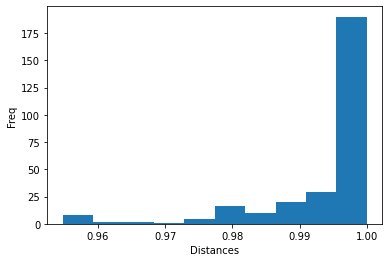

In [10]:
#plot HIST of largest similarity

%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(largest)
#plt.hist(largest)
plt.xlabel('Distances')
plt.ylabel('Freq')
#plt.ylim(0,100)
#plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/tg1e3_split_lsim.png')
plt.show()

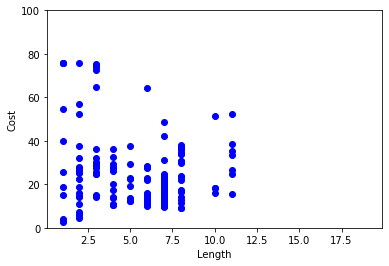

In [49]:
#plot SCATTER of largest similarity for explore against all normal

%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(lengths, costs, c='b')
#plt.hist(largest)
plt.ylabel('Cost')
plt.xlabel('Length')
#plt.ylim(0,20)
plt.ylim(0,100)
#plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/experiments/target_2/results/images/tg2_opt3_lenvscost_2.png')
plt.show()

In [46]:
print(sum(1 if i.get('cost' ) < 100 else 0 for i in explore_reactions))

188


In [10]:
# fingerprint distance calculations
distances, largest_distances, reactions_dict = fings.calculate_distances(fingerprints)

KeyboardInterrupt: 

In [16]:
none_one = [i for i in largest if i != 1.0]
print(len(none_one))
print(len(largest))

2
705


In [9]:
# fingerprint similarity calculations
dists, smallest_sim, largest_sim, reactions_dict_2, lengths = fings.calculate_similarity(reactions_dict)

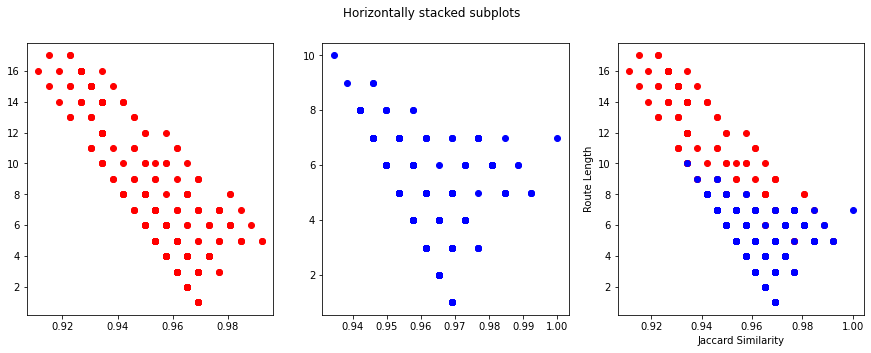

In [21]:
#plot SCATTER of largest similarity + route length

largest_sim_e = [i for index, i in enumerate(largest_sim) if reactions_dict_2[index].get('type') == 'explore']
largest_sim_s = [i for index, i in enumerate(largest_sim) if reactions_dict_2[index].get('type') == 'normal']
lengths_e = [i for index, i in enumerate(lengths) if reactions_dict_2[index].get('type') == 'explore']
lengths_s = [i for index, i in enumerate(lengths) if reactions_dict_2[index].get('type') == 'normal']


%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Horizontally stacked subplots')
ax1.scatter(largest_sim_e, lengths_e, c='red')
ax2.scatter(largest_sim_s, lengths_s, c='blue')
ax3.scatter(largest_sim_e, lengths_e, c='red')
ax3.scatter(largest_sim_s, lengths_s, c='blue')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Route Length')
#plt.ylim(0,100)
#plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/tg1_all_sim+len.png')
plt.show()

In [19]:
#find routes that have similarity ca. 0.9 and length 10 - 12
indexes = []
for index, (x, y) in enumerate(zip(largest_sim, lengths)):
    if x < 0.92 and 10 <= y <= 14:
        indexes.append(index)
print(indexes)

[363]


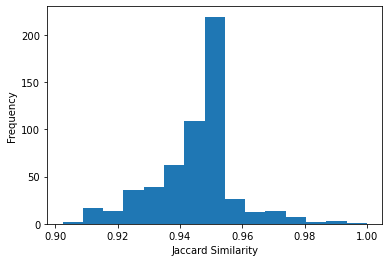

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(len(largest_sim))
plt.hist(smallest_sim, bins=15)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
#plt.ylim(0,100)
#plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/tg1_exp_all_msim.png')
plt.show()

In [13]:
zeros=[i for i in largest_sim if i < 0.90]
print(len(zeros))

print(len(largest_sim))

indexes = [index for index, item in enumerate(smallest_sim) if item >= 0.975]
print(indexes)

0
563
[20, 103, 107, 234, 249, 289, 293, 409, 438, 454, 475, 561, 562]


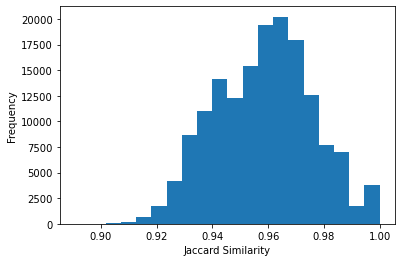

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(len(smallest_sim))
plt.hist(dists, bins=20)
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
#plt.ylim(0,100)
plt.savefig('/data/localhost/not-backed-up/mokaya/exscientia/aizynthfinder/Maranga/Images/tg1_std_all_jacc.png')
plt.show()